In [1]:
import numpy as np
import import_ipynb
import os
from lab1 import *

importing Jupyter notebook from lab1.ipynb


In [2]:
def mul_sequence(*args):
    result, flops, mults = None, 0, 0
    for arg in args:
        if result is None:
            result = arg
        else:
            result, f, m = strassen_multiply(result, arg)
            flops += f
            mults += m
    return result, flops, mults

In [3]:
def divide(A, X, Y):
    return A[:X//2,:Y//2],A[:X//2,Y//2:],A[X//2:,:Y//2],A[X//2:,Y//2:]

In [4]:
def inverse(A):
    if A is None:
        return 0, 0, 0
    X,Y = A.shape[0],A.shape[1]
    if X != Y:
        raise ValueError
    if X==0 or Y==0:
        raise ArithmeticError
    if X==1 and Y==1:
        return 1/A, 1, 1
    else:        
        A11,A12,A21,A22 = divide(A, X, Y)

        inv_A11, flops, mults = inverse(A11)
        
        S22_partly, f, m = mul_sequence(A21,inv_A11,A12)
        S22 = A22 - S22_partly
        flops += (A22.size+f)
        mults += m
        flops += f
        
        inv_S22, f, m = inverse(S22)
        mults += m
        flops += f
        
        B11_partly, B11f, B11m = mul_sequence(inv_A11, A12, inv_S22, A21, inv_A11)
        B11 = inv_A11 + B11_partly
        flops += B11.size
        
        B12, B12f, B12m = mul_sequence(-inv_A11, A12, inv_S22)
        B21, B21f, B21m = mul_sequence(-inv_S22, A21, inv_A11)
        B22 = inv_S22
        
        U = np.hstack((B11,B12))
        L = np.hstack((B21,B22))
        flops += sum((B12f, B21f, B11f))
        mults += sum((B12m, B21m, B11m))
        return np.vstack((U,L)), flops, mults

In [5]:
def LU(A):
    if A is None:
        return 0, 0, 0, 0
    X,Y = A.shape[0],A.shape[1]
    if X != Y:
        raise ValueError
    if X==0 or Y==0:
        raise ArithmeticError
    if X==1 and Y==1:
        return np.array([[1]]), A, 1, 1
    else:        
        A11,A12,A21,A22 = divide(A, X, Y)

        L11, U11, flops, mults = LU(A11)
        
        inv_U11, fu, mu = inverse(U11)
        inv_L11, fl, ml = inverse(L11)
        flops += (fu + fl)
        mults += (mu + ml)
        
        S_partly, Sf, Sm = mul_sequence(A21, inv_U11, inv_L11, A12)
        S = A22 - S_partly
        flops += (Sf + A22.size)
        mults += Sm
        
        Ls, Us, f, m= LU(S)
        flops += f
        mults += m
        
        U12, f, m = mul_sequence(inv_L11,A12)
        flops += f
        mults += m
        U21 = np.zeros((Us.shape[0],U11.shape[1]))
        
        L12 = np.zeros((L11.shape[0],Ls.shape[1]))
        L21, f, m = mul_sequence(A21, inv_U11)
        flops += f
        mults += m
        
        Uu = np.hstack((U11,U12))
        Ul = np.hstack((U21,Us))
        U = np.vstack((Uu,Ul))
        
        Lu = np.hstack((L11,L12))
        Ll = np.hstack((L21,Ls))
        L = np.vstack((Lu,Ll))
        
        return L, U, flops, mults

In [6]:
def det(A):
    if A is None:
        return 0, 0, 0
    X,Y = A.shape[0],A.shape[1]
    if X != Y:
        raise ValueError
    if X==0 or Y==0:
        raise ArithmeticError
    if X==1 and Y==1:
        return A[0,0], 0, 0
    else:        
        A11,A12,A21,A22 = divide(A, X, Y)
        L11, U11, flops, mults= LU(A11)
        
        inv_U11, fu, mu = inverse(U11)
        inv_L11, fl, ml = inverse(L11)
        
        flops += fu + fl
        mults += mu + ml
        
        S_partly, Sf, Sm = mul_sequence(A21, inv_U11, inv_L11, A12)
        S = A22 - S_partly
        flops += (Sf + A22.size)
        mults += Sm
        
        
        det_S, Sf, Sm = det(S)
        diagonals_product = np.prod(np.diagonal(U11))*np.prod(np.diagonal(L11))
        return diagonals_product*det_S, flops + Sf + np.diagonal(U11).size, mults + Sm + np.diagonal(U11).size

In [7]:
A = np.random.random((3,3))

In [8]:
inverse(A)

(array([[-0.61951111,  2.41497192, -1.74985029],
        [ 3.37206951, -4.89648321,  2.03198487],
        [-0.31127492,  0.41906195,  0.94255266]]),
 62,
 40)

In [9]:
np.linalg.inv(A)

array([[-0.61951111,  2.41497192, -1.74985029],
       [ 3.37206951, -4.89648321,  2.03198487],
       [-0.31127492,  0.41906195,  0.94255266]])

In [10]:
L, U, flops, mults = LU(A)

In [11]:
L, U

(array([[ 1.        ,  0.        ,  0.        ],
        [ 0.69710145,  1.        ,  0.        ],
        [ 0.02031316, -0.44460322,  1.        ]]),
 array([[ 0.97236129,  0.5353034 ,  0.65116603],
        [ 0.        , -0.17241646,  0.37170087],
        [ 0.        ,  0.        ,  1.06094868]]))

In [12]:
L@U-A

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.46944695e-18,  0.00000000e+00, -1.11022302e-16]])

In [13]:
flops, mults

(29, 24)

In [14]:
det(A)

(-0.17786920503418724, 24, 19)

In [15]:
np.linalg.det(A)

-0.17786920503418727

In [16]:
A

array([[0.97236129, 0.5353034 , 0.65116603],
       [0.67783446, 0.20074432, 0.82562965],
       [0.01975174, 0.08753062, 0.90891652]])

In [17]:
test_sizes = [(i,i)for i in range(2,200)]
methods = inverse, LU, det

In [18]:
def test(method_id, A):
    if method_id ==0:
        start = dt.datetime.now()
        result, flops, mults = inverse(A)
        end = dt.datetime.now()
        check = result@A
        diff = np.sum(check - np.eye(A.shape[0]))**2/A.size
    if method_id ==1:
        start = dt.datetime.now()
        L, U, flops, mults = LU(A)
        end = dt.datetime.now()
        check = L@U
        diff = np.sum(check - A)**2/A.size
    if method_id ==2:
        start = dt.datetime.now()
        result, flops, mults = det(A)
        end = dt.datetime.now()
        check = np.linalg.det(A)
        diff = abs(result-check)/check
    time = (end-start).total_seconds()
    if (method_id!=2 and diff > 10**(-4)) or (method_id==2 and diff >0.01):
        #sprawdzam, czy błąd kwadratowy nie jest za duży, mały może być - stosujemy w końcu różne algorytmy numeryczne
        print(diff)
        print(A.shape[0])
        raise ArithmeticError
    return flops, mults, time

In [19]:
def perform_tests():
    results = [[] for i in range(3)]
    for size in test_sizes:
        A = np.random.random(size[:2])
        for i in range(3):
            results[i].append(test(i, A))
    return results

In [20]:
def polynomial(p, x):
    y = np.zeros(x.shape)
    for i, a in enumerate(p[::-1]):
        y += a*(x**i)
    return y
def plot_results(results):
    method_names = ["matrix inversion","LU factorization", "determinant computing"]
    values = ["FLOAT OPERATIONS","FLOAT MULTIPLICATIONS","TIME [s]"]
    for value in range(3):
        X = np.linspace(test_sizes[0][0],test_sizes[-1][0],1000)
        for m in range(3):
            x = [i[0] for i in test_sizes]
            y = [i[value] for i in results[m]]
            p =approx = np.polyfit(x,y,3)
            Y = polynomial(p, X)
            plt.plot(X,Y)
            plt.scatter(x,y,marker =(5,m))
            plt.legend(np.array([[m+" estimation",m] for m in method_names]).reshape(-1))
            plt.xlabel("matrix side size")
            plt.ylabel(values[value])
            plt.title(values[value]+" depending on matrices sizes")
            #plt.legend(np.array([[m,m] for m in method_names]).reshape(-1))
        plt.show()

In [21]:
results = perform_tests()

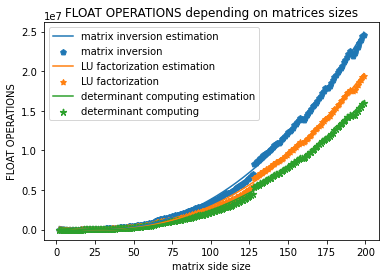

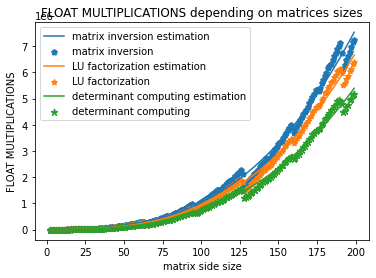

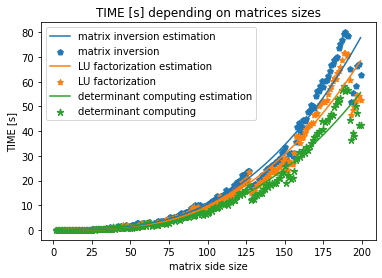

In [22]:
plot_results(results)